## **Projet BI - Lilia HARIRECHE - M2 MLDS FA**

### **Partie 1**

**1. Chargement des packages**


In [ ]:
# 1 #package 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from textblob import Word
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
import re
import community 
import networkx as nx 
from sklearn.feature_extraction.text import CountVectorizer
from functools import reduce


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**2. Extraction des articles à partir du fichier texte**

In [ ]:
#2 # extraire les articles
f = open("/content/DBLP_new_version.txt", "r")
data = f.read().split(sep='\n\n')  

#create a dataframe
df = pd.DataFrame(columns=['Title','Abstract','ListCitation','Id', 'Venue','Year', 'Authors'])

**3. Traitement et récuperation des données**

In [ ]:
#3 #Récuperation des données:
Abstract = []
Title= []
Year = []
Venue = []
ListCitation = []
Authors = []
Id = []
with open("/content/DBLP_new_version.txt", "r") as fichier:
    ligne = fichier.readline()
    while ligne != '':
      if ("#*") in ligne:
        Title.append(ligne)
      if ("#!") in ligne: 
        Abstract.append(ligne)
      if ("#t") in ligne : 
        Year.append(ligne)
      if ("#c") in ligne : 
        Venue.append(ligne)
      if ("#%") in ligne : 
        ListCitation.append(ligne)
      if ("#@") in ligne : 
        Authors.append(ligne)
      if ("#index") in ligne : 
        Id.append(ligne)        
      ligne = fichier.readline()

#création du data frame article

df = pd.DataFrame(list(zip(Venue, Year, Authors, Title, Id,Abstract ,ListCitation)),
               columns =['Venue', 'Year', 'Authors', 'Title', 'Id','Abstract','ListCitation']) 

In [ ]:
##### Traitement des colonnes ######
#traitement Venue
df['Venue'] = df['Venue'].str.replace('#c','')
df['Venue'] = df['Venue'].str.replace('[\n]',' ')
df['Venue'] = df['Venue'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [ ]:
#traitement Year
df['Year'] = df['Year'].str.replace('#t',' ')
df['Year'] = df['Year'].str.replace('[\n]',' ')

In [ ]:
#traitement Authors
df['Authors'] = df['Authors'].str.replace('#@',' ')
df['Authors'] = df['Authors'].str.replace('[\n]',' ')
df['Authors'] = df['Authors'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['Authors'] = df['Authors'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))


In [ ]:
#traitement titre
df['Title'] = df['Title'].str.replace('#','')
df['Title'] = df['Title'].str.replace('*','')
df['Title'] = df['Title'].str.replace('[\n]',' ')
df['Title'] = df['Title'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['Title'] = df['Title'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [ ]:
# traitement Id
df['Id'] = df['Id'].str.replace('#index',' ')
df['Id'] = df['Id'].str.replace('[\n]',' ')

In [ ]:
# traitement Abstract

df['Abstract'] = df['Abstract'].apply(lambda x: " ".join(x.lower() for x in x.split()))
stop = stopwords.words('french') + stopwords.words('english')
stop = np.unique(stop).tolist()
df['Abstract'] = df['Abstract'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['Abstract'] = df['Abstract'].str.replace('#!','')
df['Abstract'] = df['Abstract'].str.replace('[\n]',' ')
df['Abstract'] = df['Abstract'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [ ]:
# traitement ListCitation
df['ListCitation'] = df['ListCitation'].str.replace('#%',' ')
df['ListCitation'] = df['ListCitation'].str.replace('[\n]',' ')

In [ ]:
#il faut qu'on supprime les articles avec des val manquantes
nan_value = float("NaN") 
df.replace("", nan_value, inplace=True)
df = df.dropna(subset=["Abstract"])
df = df.dropna(subset=["Title"])
df = df.dropna(subset=["Id"])
df = df.dropna(subset=["Authors"])
df = df.dropna(subset=["Venue"])

In [ ]:
# Get names of indexes for which column Stock has value SIGIR,STOC,SIGMOD
index = df[ (df['Venue'] != 'SIGIR') & (df['Venue'] != 'STOC') & (df['Venue'] != 'SIGMOD') ].index
df.drop(index , inplace=True)
df.drop(df.index[3000:4409],0,inplace=True)

**4. Création des matrices co-terme (titre & abstract)**

In [ ]:
#4 #matrice document terme pour les titres

title_vectorizer = CountVectorizer(max_features=2000, lowercase=True, ngram_range=(1,1), analyzer="word")

doc_term_titre = title_vectorizer.fit_transform(list(df['Title'])) 
doc_term_titre_dense = doc_term_titre.todense() 
title_words = np.asarray(title_vectorizer.get_feature_names())


In [ ]:
#Ajouter la colonne id à la matricee doc_term_titre
doc_term_titre_dense = np.c_[df['Id'],doc_term_titre_dense]
#df_doc_term_titre
df_doc_term_titre = pd.DataFrame(doc_term_titre_dense)
df_doc_term_titre = df_doc_term_titre.rename(columns = {0: 'Id'})

In [ ]:
#4 #matrice document terme pour les abstract

abstract_vectorizer = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1,1), analyzer="word")

doc_term_abstract = abstract_vectorizer.fit_transform(list(df['Abstract'])) 
doc_term_abstract_dense = doc_term_abstract.todense() 
abstract_words = np.asarray(abstract_vectorizer.get_feature_names())  


In [ ]:
#Ajouter la colonne id à la matrice doc_term_abstract
doc_term_abstract_dense= np.c_[df['Id'],doc_term_abstract_dense]
#df_doc_term_titre
df_doc_term_abstract = pd.DataFrame(doc_term_abstract_dense)
df_doc_term_abstract = df_doc_term_abstract.rename(columns = {0: 'Id'})

**5. Création du DF contenant les auteurs**


In [ ]:
#5 #dataframe représentant les auteurs et attribuer à chaque auteur un identifiant ‘id_auteur’.
#extraire les auteurs:
def splitAuthor(Authors):
  temp = Authors.lower()
  splitted_Authors = []
  for Author in temp.split(","):   #supprimer les caractères de début et de fin
    splitted_Authors.append(Author.strip())
  return splitted_Authors

df["splitted_Authors"] = df["Authors"].apply(splitAuthor)
#print(df["splitted_Authors"])
df["splitted_Authors"].shape
#extraire toute la liste d'auteurs uniques
all_Authors = [i for a in df["splitted_Authors"] for i in a]
len(all_Authors)
unique_Auteurs = np.unique(all_Authors)
len(unique_Auteurs)

#création des id_auteur
i=0
id_auteur = []
for a in unique_Auteurs:
  id_auteur.append('id_' + str(i))
  i=i+1
#dataframe auteur
df_author= pd.DataFrame(list(zip(id_auteur, unique_Auteurs)), columns =['id_Author', 'Author'])

**6. Création de la matrice doc-auteur**

In [ ]:
#6 #matrice ducument auteur
doc_author = np.zeros((df.shape[0], len(unique_Auteurs)))

for i in unique_Auteurs:
  for a in df["splitted_Authors"]:
    if i in a:
      doc_author[doc_author == 0] =1

In [ ]:
#Ajouter la colonne id_auteur à la matricee doc_author
doc_author= np.c_[df['Id'], doc_author]
#df_doc_term_titre
df_doc_author = pd.DataFrame(doc_author)
df_doc_author = df_doc_author.rename(columns = {0: 'Id'})

In [ ]:
#  créer la colonne NbrAuthors 
NbrAuthors=[]
for i in df['Authors'].shape:
  for author in df['Authors']:
    s=len(author.split(','))
    NbrAuthors.append(s)

In [ ]:
del df["splitted_Authors"]
#ajout de la colonne NbrAuthors au dataframe
df['NbrAuthors'] = NbrAuthors

In [ ]:
#Appel au DF obtenus après les avoir crées

df = pd.read_csv("/content/df_articles.csv", delimiter = ";")
df_author = pd.read_csv("/content/df_auteur.csv", delimiter = ";")
df_doc_author = pd.read_csv("/content/df_doc_auteur.csv", delimiter = ";")
df_doc_term_abstract = pd.read_csv("/content/df_doc_term_resume.csv", delimiter = ";")
df_doc_term_titre = pd.read_csv("/content/df_doc_term_titre.csv", delimiter = ";")

### **Partie 2**

**Transformation des DF obtenus en fichier CSV**

In [ ]:
#Transformer les dataframe créés précédemment en ficheir CSV et charger ces derniers sur Qlik Sense
#DF
df.to_csv('df_articles', header=True, index=False, sep = ";") 


In [ ]:
#df_doc_term_titre
df_doc_term_titre.to_csv('df_doc_term_titre', header=True, index=False, sep = ";")
 

In [ ]:
#df_doc_term_abstract
df_doc_term_abstract.to_csv('df_doc_term_resume', header=True, index=False, sep = ";") 


In [ ]:
#df_author
df_author.to_csv('df_auteur', header=True, index=False, sep = ";")


In [ ]:
#df_doc_author
df_doc_author.to_csv('df_doc_auteur', header=True, index=False, sep = ";")

### **Partie 3** 

**10. Graphes co-termes (titre), co-termes (abstract), co-auteurs**

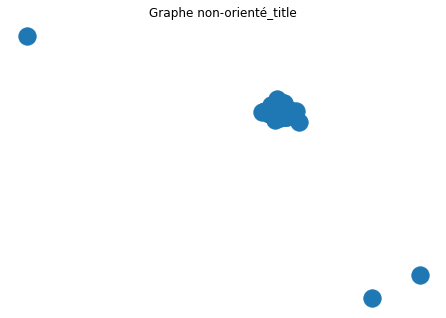

In [ ]:
#9 ---> #pour cette question(9), la réponse a été realisée dans la partie 1

#10 

#graphe co-termes (titre)
#matrice d'adj
mat_adj_titre = doc_term_titre_dense.dot(np.transpose(doc_term_titre_dense))
mat_adj_titre
mat_adj_titre.shape

# création du graphe à l’aide du package networkx
g_titre = nx.from_numpy_matrix(mat_adj_titre) 
# Affichage du gaphe
nx.draw(g_titre)
plt.title("Graphe non-orienté_title") 
plt.show()



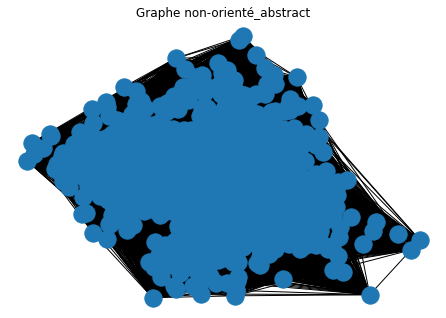

In [ ]:
#graphe co-termes (abstract)
#matrice d'adj
mat_adj_abstract = doc_term_abstract_dense.dot(np.transpose(doc_term_abstract_dense))
mat_adj_abstract
mat_adj_abstract.shape

# création du graphe
g_abstract = nx.from_numpy_matrix(mat_adj_abstract) 
# Affichage du gaphe
nx.draw(g_abstract)
plt.title("Graphe non-orienté_abstract") 
plt.show()

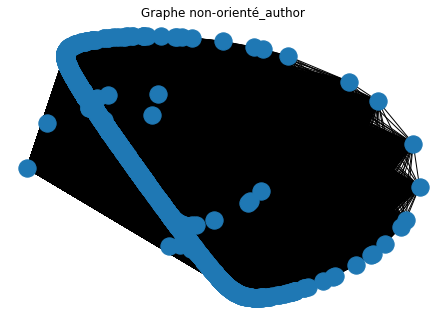

In [ ]:
#graphe co-auteurs
#matrcie d'adjacence
mat_adj_authors = doc_author.dot(np.transpose(doc_author)) 
mat_adj_authors.shape

# création du graphe
g_authors = nx.from_numpy_matrix(mat_adj_authors) 
# Affichage du gaphe
nx.draw(g_authors)
plt.title("Graphe non-orienté_author") 
plt.show()

**11. Réalisation d'un clustering à l'aide de l'algorithme de Louvain**

**Partition title**

partition_titre {0: 0, 1: 1, 2: 1, 3: 2, 4: 2, 5: 0, 6: 3, 7: 3, 8: 1, 9: 3, 10: 2, 11: 4, 12: 2, 13: 2, 14: 2, 15: 2, 16: 4, 17: 0, 18: 1, 19: 2, 20: 1, 21: 0, 22: 2, 23: 2, 24: 1, 25: 4, 26: 2, 27: 2, 28: 1, 29: 2, 30: 2, 31: 1, 32: 2, 33: 2, 34: 4, 35: 2, 36: 2, 37: 4, 38: 0, 39: 1, 40: 0, 41: 4, 42: 2, 43: 2, 44: 1, 45: 1, 46: 0, 47: 3, 48: 0, 49: 1, 50: 2, 51: 0, 52: 2, 53: 4, 54: 1, 55: 0, 56: 4, 57: 0, 58: 3, 59: 0, 60: 0, 61: 4, 62: 1, 63: 1, 64: 1, 65: 4, 66: 0, 67: 2, 68: 1, 69: 4, 70: 4, 71: 0, 72: 2, 73: 2, 74: 3, 75: 1, 76: 3, 77: 1, 78: 0, 79: 3, 80: 1, 81: 2, 82: 3, 83: 1, 84: 1, 85: 1, 86: 2, 87: 0, 88: 1, 89: 4, 90: 1, 91: 3, 92: 1, 93: 4, 94: 1, 95: 1, 96: 1, 97: 1, 98: 3, 99: 0, 100: 4, 101: 0, 102: 4, 103: 1, 104: 3, 105: 4, 106: 4, 107: 4, 108: 3, 109: 1, 110: 4, 111: 4, 112: 4, 113: 3, 114: 0, 115: 4, 116: 2, 117: 0, 118: 2, 119: 2, 120: 2, 121: 2, 122: 2, 123: 3, 124: 4, 125: 1, 126: 3, 127: 0, 128: 2, 129: 2, 130: 4, 131: 4, 132: 3, 133: 1, 134: 2, 135: 0, 136: 

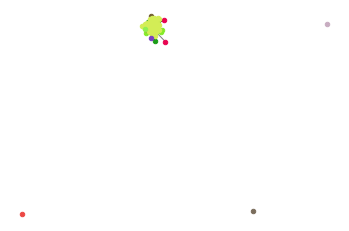

In [ ]:
#11 #Réaliser un clustering à l’aide à l’aide de l’algorithme de Louvain sur les quatre graphes.

#### partition titre ##########

from random import choice

partition_titre = community.best_partition(g_titre) 
print("partition_titre", partition_titre) 

# Calcul de la modularité liée à cette parition 
modularity_value = community.modularity(partition_titre, g_titre) 
print("modularity_value", modularity_value) 

# Visulalisation du nombre de communautés retrouvé 
vect_label = set(partition_titre.values()) 
print("vect_label", vect_label) 
size = int(len(set(partition_titre.values()))) 
print("size", size) 

# générer un vecteur de couleurs = au nombre de communautés 
colors= ["#"+''.join([choice('0123456789ABCDEF') for j in range(6)]) for i in range(size)] 

# Affichage du graphe 
pos = nx.spring_layout(g_titre) 
count = 0 
for com in set(partition_titre.values()) : 
    list_nodes = [nodes for nodes in partition_titre.keys() if partition_titre[nodes] == com]
    nx.draw_networkx_nodes(g_titre, pos, list_nodes, node_size = 20, node_color = (colors[count])) 
    count += 1 
nx.draw_networkx_edges(g_titre, pos, alpha=0.5) 
plt.axis("off") 
plt.show()


**Partition abstract**

partition_abstract {0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 2, 7: 0, 8: 0, 9: 1, 10: 3, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 1, 20: 3, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 2, 30: 0, 31: 1, 32: 1, 33: 0, 34: 0, 35: 3, 36: 0, 37: 0, 38: 0, 39: 0, 40: 1, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 2, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 1, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 2, 63: 1, 64: 3, 65: 2, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 3, 80: 0, 81: 0, 82: 1, 83: 1, 84: 0, 85: 0, 86: 1, 87: 0, 88: 3, 89: 0, 90: 3, 91: 0, 92: 0, 93: 0, 94: 2, 95: 2, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 1, 104: 2, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 1, 122: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 130: 0, 131: 0, 132: 0, 133: 3, 134: 2, 135: 0, 13

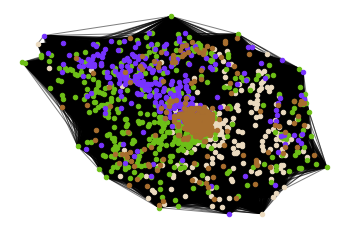

In [ ]:
#############  partition abstract ############

partition_abstract = community.best_partition(g_abstract) 
print("partition_abstract", partition_abstract)

# Calcul de la modularité liée à cette parition 
modularity_value = community.modularity(partition_abstract, g_abstract) 
print("modularity_value", modularity_value) 

# Visulalisation du nombre de communautés retrouvé 
vect_label = set(partition_abstract.values()) 
print("vect_label", vect_label) 
size = int(len(set(partition_abstract.values()))) 
print("size", size) 

# générer un vecteur de couleurs = au nombre de communautés 
colors= ["#"+''.join([choice('0123456789ABCDEF') for j in range(6)]) for i in range(size)] 

# Affichage du graphe 
pos = nx.spring_layout(g_abstract) 
count = 0 
for com in set(partition_abstract.values()) : 
    list_nodes = [nodes for nodes in partition_abstract.keys() if partition_abstract[nodes] == com]
    nx.draw_networkx_nodes(g_abstract, pos, list_nodes, node_size = 20, node_color = (colors[count])) 
    count += 1 
nx.draw_networkx_edges(g_abstract, pos, alpha=0.5) 
plt.axis("off") 
plt.show()


**Partiton authors**

partition_authors {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36, 37: 37, 38: 38, 39: 39, 40: 40, 41: 41, 42: 42, 43: 43, 44: 44, 45: 45, 46: 46, 47: 47, 48: 48, 49: 49, 50: 50, 51: 51, 52: 52, 53: 53, 54: 54, 55: 55, 56: 56, 57: 57, 58: 58, 59: 59, 60: 60, 61: 61, 62: 62, 63: 63, 64: 64, 65: 65, 66: 66, 67: 67, 68: 68, 69: 69, 70: 70, 71: 71, 72: 72, 73: 73, 74: 74, 75: 75, 76: 76, 77: 77, 78: 78, 79: 79, 80: 80, 81: 81, 82: 82, 83: 83, 84: 84, 85: 85, 86: 86, 87: 87, 88: 88, 89: 89, 90: 90, 91: 91, 92: 92, 93: 93, 94: 94, 95: 95, 96: 96, 97: 97, 98: 98, 99: 99, 100: 100, 101: 101, 102: 102, 103: 103, 104: 104, 105: 105, 106: 106, 107: 107, 108: 108, 109: 109, 110: 110, 111: 111, 112: 112, 113: 113, 114: 114, 115: 115, 116: 116, 117: 117, 118: 118, 119: 119, 1

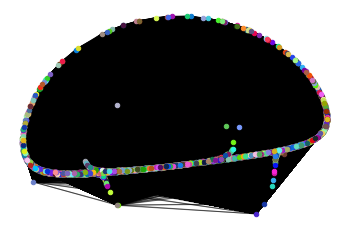

In [ ]:
###########  partition authors  ############

partition_authors = community.best_partition(g_authors) 
print("partition_authors", partition_authors) 

# Calcul de la modularité liée à cette parition 
modularity_value = community.modularity(partition_authors, g_authors) 
print("modularity_value", modularity_value) 

# Visulalisation du nombre de communautés retrouvé 
vect_label = set(partition_authors.values()) 
print("vect_label", vect_label) 
size = int(len(set(partition_authors.values()))) 
print("size", size) 

# générer un vecteur de couleurs = au nombre de communautés 
colors= ["#"+''.join([choice('0123456789ABCDEF') for j in range(6)]) for i in range(size)] 

# Affichage du graphe 
pos = nx.spring_layout(g_authors) 
count = 0 
for com in set(partition_authors.values()) : 
    list_nodes = [nodes for nodes in partition_authors.keys() if partition_authors[nodes] == com]
    nx.draw_networkx_nodes(g_authors, pos, list_nodes, node_size = 20, node_color = (colors[count])) 
    count += 1 
nx.draw_networkx_edges(g_authors, pos, alpha=0.5) 
plt.axis("off") 
plt.show()


**12. Réaliser un consensus entre les partitions découvertes par les clustering précédents**

In [ ]:
  # pour installer cluster_ensemble

!pip install Cluster_Ensembles
!pip -v list
!sudo apt-get install metis


In [ ]:
import Cluster_Ensembles as CE 

cluster_runs = np.array([list(partition_abstract.values()),
                         list(partition_titre.values()),
                         list(partition_authors.values())])
print("cluster_runs", cluster_runs) 



cluster_runs [[   0    0    0 ...    1    1    1]
 [   0    1    1 ...    3    0    0]
 [   0    1    2 ... 2997 2998 2999]]


In [ ]:
#Consensus

consensus_clustering_labels = CE.cluster_ensembles(cluster_runs, verbose = True, N_clusters_max = 16) 
print("consensus_clustering_labels", consensus_clustering_labels)

*****
INFO: Cluster_Ensembles: CSPA: consensus clustering using CSPA.

#
INFO: Cluster_Ensembles: wgraph: writing wgraph_CSPA.
#

#
INFO: Cluster_Ensembles: sgraph: calling gpmetis for graph partitioning.
INFO: Cluster_Ensembles: sgraph: (hyper)-graph partitioning completed; loading wgraph_CSPA.part.16
#

INFO: Cluster_Ensembles: cluster_ensembles: CSPA at 0.560309897944627.
*****

*****
INFO: Cluster_Ensembles: HGPA: consensus clustering using HGPA.

#
INFO: Cluster_Ensembles: wgraph: writing wgraph_HGPA.
INFO: Cluster_Ensembles: wgraph: 3000 vertices and 3014 non-zero hyper-edges.
#

#
INFO: Cluster_Ensembles: sgraph: calling shmetis for hypergraph partitioning.
INFO: Cluster_Ensembles: sgraph: (hyper)-graph partitioning completed; loading wgraph_HGPA.part.16
#

INFO: Cluster_Ensembles: cluster_ensembles: HGPA at 0.1742826021866589.
*****

*****
INFO: Cluster_Ensembles: MCLA: consensus clustering using MCLA.
INFO: Cluster_Ensembles: MCLA: preparing graph for meta-clustering.
INFO: Cl

In [ ]:
partition_consensus = {i:x for i,x in enumerate(consensus_clustering_labels )}

In [ ]:
partition_consensus

{0: 15,
 1: 15,
 2: 15,
 3: 8,
 4: 4,
 5: 15,
 6: 12,
 7: 15,
 8: 15,
 9: 6,
 10: 1,
 11: 0,
 12: 11,
 13: 11,
 14: 10,
 15: 11,
 16: 14,
 17: 15,
 18: 15,
 19: 4,
 20: 2,
 21: 15,
 22: 10,
 23: 15,
 24: 15,
 25: 10,
 26: 15,
 27: 10,
 28: 15,
 29: 12,
 30: 10,
 31: 4,
 32: 4,
 33: 10,
 34: 10,
 35: 1,
 36: 10,
 37: 11,
 38: 8,
 39: 15,
 40: 7,
 41: 10,
 42: 10,
 43: 10,
 44: 14,
 45: 14,
 46: 8,
 47: 12,
 48: 8,
 49: 14,
 50: 10,
 51: 8,
 52: 10,
 53: 6,
 54: 14,
 55: 8,
 56: 15,
 57: 8,
 58: 15,
 59: 8,
 60: 8,
 61: 9,
 62: 13,
 63: 4,
 64: 2,
 65: 12,
 66: 8,
 67: 10,
 68: 14,
 69: 9,
 70: 9,
 71: 8,
 72: 10,
 73: 10,
 74: 15,
 75: 14,
 76: 15,
 77: 14,
 78: 8,
 79: 3,
 80: 14,
 81: 10,
 82: 6,
 83: 4,
 84: 14,
 85: 14,
 86: 4,
 87: 8,
 88: 2,
 89: 9,
 90: 2,
 91: 15,
 92: 14,
 93: 9,
 94: 13,
 95: 13,
 96: 14,
 97: 14,
 98: 15,
 99: 8,
 100: 9,
 101: 8,
 102: 9,
 103: 4,
 104: 12,
 105: 9,
 106: 9,
 107: 9,
 108: 15,
 109: 14,
 110: 9,
 111: 9,
 112: 9,
 113: 15,
 114: 8,
 115: 9,


**Graphes doc-terme (title et abstract) et doc-auteur via la partition consensus**

**Title via la partition consensus**

vect_label {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
size 16


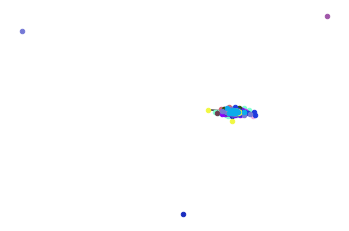

In [ ]:
#titre via la partition consensus  
# Visulalisation du nombre de communautés retrouvé 
vect_label = set(partition_consensus.values()) 
print("vect_label", vect_label) 
size = int(len(set(consensus_clustering_labels)))
print("size", size) 
# générer un vecteur de couleurs = au nombre de communautés 
colors= ["#"+''.join([choice('0123456789ABCDEF') for j in range(6)]) for i in range(size)] 
# Affichage du graphe 
pos = nx.spring_layout(g_titre) 

count = 0 
for com in set(consensus_clustering_labels) : 
    list_nodes = [nodes for nodes in partition_consensus.keys() if partition_consensus[nodes] == com]        
    nx.draw_networkx_nodes(g_titre, pos, list_nodes, node_size = 20, node_color = (colors[count])) 
    count += 1 
nx.draw_networkx_edges(g_titre, pos, alpha=0.5) 
plt.axis("off") 
plt.show() 

**Abstract via la partition consensus**

vect_label {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
size 16


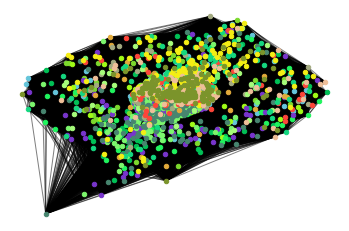

In [ ]:
#abstract via la partition concensus
# Visulalisation du nombre de communautés retrouvé 
vect_label = set(partition_consensus.values()) 
print("vect_label", vect_label) 
size = int(len(set(consensus_clustering_labels)))
print("size", size) 
# générer un vecteur de couleurs = au nombre de communautés 
colors= ["#"+''.join([choice('0123456789ABCDEF') for j in range(6)]) for i in range(size)] 
# Affichage du graphe 
pos = nx.spring_layout(g_abstract) 

count = 0 
for com in set(consensus_clustering_labels) : 
    list_nodes = [nodes for nodes in partition_consensus.keys() if partition_consensus[nodes] == com]        
    nx.draw_networkx_nodes(g_abstract, pos, list_nodes, node_size = 20, node_color = (colors[count])) 
    count += 1 
nx.draw_networkx_edges(g_abstract, pos, alpha=0.5) 
plt.axis("off") 
plt.show() 

**Author via la partition consensus**

vect_label {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
size 16


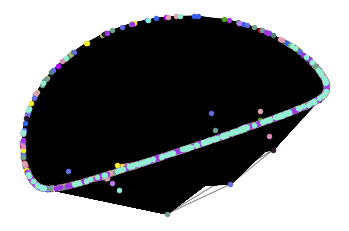

In [ ]:
#author via la partition concensus
# Visulalisation du nombre de communautés retrouvé 
vect_label = set(partition_consensus.values()) 
print("vect_label", vect_label) 
size = int(len(set(consensus_clustering_labels)))
print("size", size) 
# générer un vecteur de couleurs = au nombre de communautés 
colors= ["#"+''.join([choice('0123456789ABCDEF') for j in range(6)]) for i in range(size)] 
# Affichage du graphe 
pos = nx.spring_layout(g_authors) 

count = 0 
for com in set(consensus_clustering_labels) : 
    list_nodes = [nodes for nodes in partition_consensus.keys() if partition_consensus[nodes] == com]        
    nx.draw_networkx_nodes(g_authors, pos, list_nodes, node_size = 20, node_color = (colors[count])) 
    count += 1 
nx.draw_networkx_edges(g_authors, pos, alpha=0.5) 
plt.axis("off") 
plt.show() 

**13. Analyser les résultats du clustering**

In [ ]:
#initialisation et création de la matrice Z:
z_mat = np.zeros((len(df), int(len(set(consensus_clustering_labels)))))
for i, x in enumerate(consensus_clustering_labels):
  z_mat[i,x] = 1

In [ ]:
abs_term = z_mat.transpose().dot(doc_term_titre_dense)
tit_term = z_mat.transpose().dot(doc_term_abstract_dense)
doc_auth = z_mat.transpose().dot(doc_author)

In [ ]:
df_abs_term = pd.DataFrame(abs_term)
df_tit_term = pd.DataFrame(tit_term)
df_doc_auth = pd.DataFrame(doc_auth)


In [ ]:
# les DF obtenus en csv
df_abs_term.to_csv('df_abs_term', header=True, index=False, sep = ";") 
df_tit_term.to_csv('df_tit_term', header=True, index=False, sep = ";") 
df_doc_auth.to_csv('df_doc_auth', header=True, index=False, sep = ";") 